In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array
import matplotlib.pyplot as plt
import seaborn as sns
from MultiSeriesWindowsGenerator import MultiSeriesWindowsGenerator
import IPython.display

2023-04-13 10:08:39.361937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option("display.max_row", 200)

In [3]:
# data_list = []
# for i in range(0, 27):
#     df = pd.read_csv(f"data/aggregated_individual_data_interpolation/interpolation/{i}_interpolated.csv",
#                      index_col=0)
#     df = pd.read_csv(f"data/aggregated_individual_data_interpolation/interpolation/{i}_interpolated.csv",
#                      index_col=0)
#     df["subject_id"] = i + 1
#     data_list.append(df)
#
# # Concatenate the data into a single dataset
# data = pd.concat(data_list)
# data.drop(["circumplex.arousal_std", "circumplex.valence_std", "mood_std", "activity_std"], inplace=True, axis=1)
#
# use_date = 0
#
# if use_date:
#     data.drop(["date"], inplace=True, axis=1)
#     date_time = pd.to_datetime(data.pop('date'))
#     df = data
#     df['days'] = date_time
#
# else:  # use days from day 0 of recording
#     data.drop(["date"], inplace=True, axis=1)
#     df = data
#
# df.reset_index(inplace=True, drop=True)
# df = df.astype({'subject_id': 'float64', 'days': 'float64', 'weekday': 'float64'})
# df = data


In [4]:
# display(df.dtypes)

In [5]:
df = pd.read_csv("data/all_data_aggr_nonan.csv", index_col=0)

In [6]:
display(df.dtypes)

weekday                   int64
mood                    float64
circumplex.arousal      float64
circumplex.valence      float64
activity                float64
screen                  float64
call                    float64
sms                     float64
appCat.builtin          float64
appCat.communication    float64
appCat.entertainment    float64
appCat.finance          float64
appCat.game             float64
appCat.office           float64
appCat.other            float64
appCat.social           float64
appCat.travel           float64
appCat.unknown          float64
appCat.utilities        float64
appCat.weather          float64
subject_id                int64
days                      int64
dtype: object

In [7]:
LABELS = ['mood']
REGRESSORS = ['weekday', 'circumplex.arousal', 'circumplex.valence',
              'activity', 'screen', 'call', 'sms', 'appCat.builtin',
              'appCat.communication', 'appCat.entertainment', 'appCat.finance',
              'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
              'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

DATE = 'days'  # always correct
IN_STEPS = 14  # use 7 days
OUT_STEPS = 14  # to predict 1 day in the future
GROUPBY = ['subject_id']
BATCH_SIZE = 8

In [8]:

n = len(df)
train_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[:int(len(x) * 0.7)]).reset_index(drop=True)
val_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.7):int(len(x) * 0.9)]).reset_index(drop=True)
test_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(
    lambda x: x.iloc[int(len(x) * 0.9):]).reset_index(drop=True)

test_window = MultiSeriesWindowsGenerator(
    input_width=IN_STEPS, label_width=OUT_STEPS, shift=1, batch_size=BATCH_SIZE, GROUPBY=GROUPBY,
    label_columns=LABELS, regressor_columns=REGRESSORS, DATE=DATE, LABELS=LABELS)

test_window.update_datasets(train_series, val_series, test_series, norm=True)

2023-04-13 10:08:44.333419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])
MAX_EPOCHS = 20

In [22]:
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

Epoch 1/20
81/81 [==============================] - 7s 44ms/step - loss: 0.4660 - mean_absolute_error: 0.4690 - val_loss: 1.6122 - val_mean_absolute_error: 0.8979
Epoch 2/20
81/81 [==============================] - 4s 23ms/step - loss: 0.3783 - mean_absolute_error: 0.3862 - val_loss: 1.4684 - val_mean_absolute_error: 0.8259
Epoch 3/20
81/81 [==============================] - 2s 20ms/step - loss: 0.3502 - mean_absolute_error: 0.3665 - val_loss: 1.5158 - val_mean_absolute_error: 0.8376
Epoch 4/20
48/48 [==============================] - 2s 7ms/step - loss: 1.6078 - mean_absolute_error: 0.8673


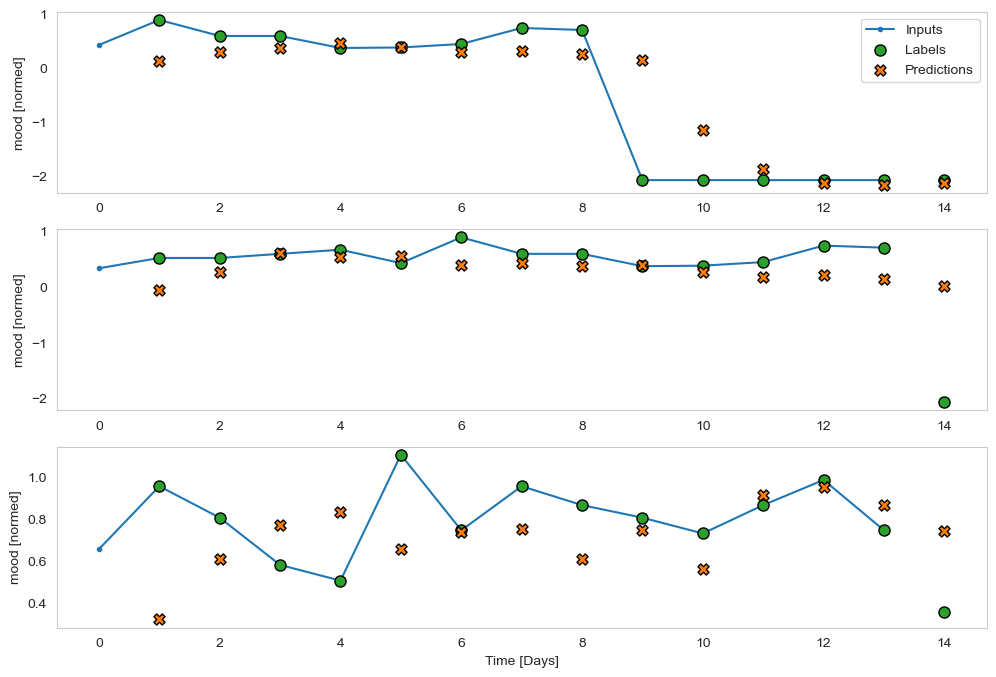

In [23]:
history = compile_and_fit(lstm_model, test_window)
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(test_window.val)
performance['LSTM'] = lstm_model.evaluate(test_window.test, verbose=0)

test_window.plot(lstm_model)

# Autoregressive RNN